**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import scipy
import sklearn
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree 
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups
import matplotlib.pyplot as plt
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors,
                 algorithm='brute', mode='base', metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.mode = mode
        self.metric = metric
        self.algorithm = algorithm

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.num_classes = np.shape(np.unique(self.y_train))[0]
        if self.algorithm == 'kd_tree':
            self.kd_tree = KDTree(self.X_train)

    def freq_count(self, X):
        freq = np.array([np.zeros(self.num_classes) for i in range(
            X.shape[0] if self.mode == 'sparse' else len(X))])
        if self.algorithm == 'brute':
            dst = pairwise_distances(X, self.X_train, metric=self.metric)
            for i in range(X.shape[0]):
                row = np.argpartition(dst[i], self.n_neighbors)
                for point in row[:self.n_neighbors]:
                    freq[i][self.y_train[point]] += 1
        else:
            ids = self.kd_tree.query(X, self.n_neighbors)[1]
            for i in range(X.shape[0]):
                for j in ids[i]:
                    freq[i][self.y_train[j]] += 1
        return freq

    def predict(self, X):
        freq = self.freq_count(X)
        return [np.argmax(elem) for elem in freq]

    def predict_proba(self, X):
        freq = self.freq_count(X)
        return freq / self.n_neighbors

    def score(self, X, y):
        return np.mean(np.array(self.predict(X)) == np.array(y))

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 658 µs, sys: 108 µs, total: 766 µs
Wall time: 898 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 63 µs, sys: 6 µs, total: 69 µs
Wall time: 73 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 1.34 ms, sys: 26 µs, total: 1.37 ms
Wall time: 1.36 ms


array([2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 2, 1, 1, 2, 0])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 1.06 ms, sys: 270 µs, total: 1.33 ms
Wall time: 1.09 ms


[2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 2, 1, 1, 2, 0]

In [12]:
%time clf.predict_proba(X_test)

CPU times: user 750 µs, sys: 36 µs, total: 786 µs
Wall time: 872 µs


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [13]:
%time my_clf.predict_proba(X_test)

CPU times: user 900 µs, sys: 32 µs, total: 932 µs
Wall time: 1 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

CPU times: user 711 µs, sys: 49 µs, total: 760 µs
Wall time: 764 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

CPU times: user 219 µs, sys: 10 µs, total: 229 µs
Wall time: 254 µs


In [18]:
%time clf.predict(X_test)

CPU times: user 1.47 ms, sys: 44 µs, total: 1.52 ms
Wall time: 1.59 ms


array([0, 1, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 2, 0])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 442 µs, sys: 5 µs, total: 447 µs
Wall time: 454 µs


[0, 1, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 2, 0]

In [20]:
%time clf.predict_proba(X_test)

CPU times: user 834 µs, sys: 27 µs, total: 861 µs
Wall time: 1.26 ms


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [21]:
%time my_clf.predict_proba(X_test)

CPU times: user 405 µs, sys: 12 µs, total: 417 µs
Wall time: 506 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
buff = []
for i, line in enumerate(data):
    buff.append("")
    for word in line:
        buff[i] += word.lower() if word.isalnum() else ' '
data_tok, train_answ_tok = zip(*[(line.split(), target[i])
                                 for i, line in enumerate(buff)
                                 if len(line) and not line.isspace()])

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
#construct sparse matrix
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
sparse_train = scipy.sparse.csr_matrix((data, indices, indptr))

In [28]:
sparse_train.shape

(11004, 98749)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [29]:
#sklearn.cross_validation deprecated so i used:
from sklearn.model_selection import cross_val_score
clf = MyKNeighborsClassifier(n_neighbors=2, mode='sparse', metric='euclidean')
cross_val_score(clf, sparse_train, train_answ_tok, cv=3)

array([0.18738102, 0.19274809, 0.19486198])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Best n_neighbors: 10


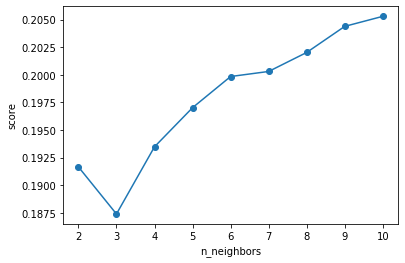

In [30]:
var = [i for i in range(2, 11)]
score = []
min_val = 0
n_best = 0
for n_neighbors in var:
    clf = MyKNeighborsClassifier(n_neighbors=n_neighbors, mode='sparse', metric='euclidean')
    result = cross_val_score(clf, sparse_train, train_answ_tok, cv=3)
    score.append(np.mean(result))
    if (np.mean(result) > min_val):
        min_val = np.mean(result)
        n_best = n_neighbors
print("Best n_neighbors:", n_best)
plt.plot(var, score, 'o-')
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [31]:
tfid = sklearn.feature_extraction.text.TfidfTransformer()
train_matrix = tfid.fit_transform(sparse_train)

Best n_neighbors: 9


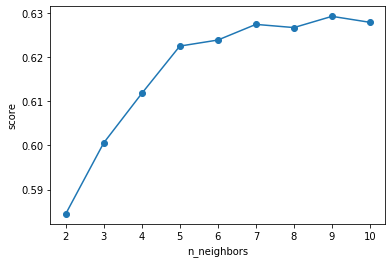

In [32]:
var = [i for i in range(2, 11)]
score = []
min_val = 0
n_best = 0
for n_neighbors in var:
    clf = MyKNeighborsClassifier(n_neighbors=n_neighbors, mode='sparse', metric='cosine')
    result = cross_val_score(clf, train_matrix, train_answ_tok, cv=3)
    score.append(np.mean(result))
    if (np.mean(result) > min_val):
        min_val = np.mean(result)
        n_best = n_neighbors
print("Best n_neighbors:", n_best)
plt.plot(var, score, 'o-')
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.show()

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [33]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [34]:
data = newsgroups['data']
target = newsgroups['target']
buff = []
for i, line in enumerate(data):
    buff.append("")
    for word in line:
        buff[i] += word.lower() if word.isalnum() else ' '
test_data_tok, test_answ_tok = zip(*[(line.split(), target[i])
                                     for i, line in enumerate(buff)
                                     if len(line) and not line.isspace()])

In [35]:
#construct sparse matrix
indptr = [0]
indices = []
data = []
for d in test_data_tok:
    for term in d:
        if term in vocabulary:
            index = vocabulary[term]
            indices.append(index)
            data.append(1)
    indptr.append(len(indices))
sparse_test = scipy.sparse.csr_matrix((data, indices, indptr))
tfid = sklearn.feature_extraction.text.TfidfTransformer()
test_matrix = tfid.fit_transform(sparse_test)

In [36]:
test_matrix.shape

(7309, 98749)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [37]:
clf_best = MyKNeighborsClassifier(n_neighbors=n_best, mode='sparse', metric='cosine')
clf_best.fit(train_matrix, train_answ_tok)
print("Test score:", clf_best.score(test_matrix, test_answ_tok))

Test score: 0.5732658366397592


Немного уменьшилась точность, одна из причин – отличие слов в тесте и обучении